# t-SNE exploration

In [42]:
### Imports

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import yfinance as yf
import yahoo_fin.stock_info as si

import numpy as np
from datetime import datetime
import pandas as pd

from sklearn.cluster import DBSCAN, OPTICS
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing


In [11]:
### List of all S&P500 tickers

SP_list = si.tickers_sp500()
len(SP_list)

505

In [12]:
### Iterating over the tickers and obtaining data

start = '01-01-2018'
end = datetime.today()

SP_historical = {}

for ticker in SP_list:
    SP_historical[ticker] = si.get_data(ticker, start_date = start, index_as_date = False, interval = '1d')

/usr/local/lib/python3.7/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()


In [15]:
SP_historical.keys()

dict_keys(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BF-B', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BLL', 'BMY', 'BR', 'BRK-B', 'BRO', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDAY', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CRL', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CTVA', 'CTXS', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISCA', '

In [18]:
### Concatenating

data = pd.concat(SP_historical)
data.head()

date       open       high  ...   adjclose   volume  ticker
A 0 2018-01-02  67.419998  67.889999  ...  65.523415  1047800       A
  1 2018-01-03  67.620003  69.489998  ...  67.190590  1698900       A
  2 2018-01-04  69.540001  69.820000  ...  66.686562  2230700       A
  3 2018-01-05  68.730003  70.099998  ...  67.752762  1632500       A
  4 2018-01-08  69.730003  70.330002  ...  67.898155  1613400       A

[5 rows x 8 columns]

In [19]:
### Pivoting

data = data.pivot(index='date', columns='ticker', values='adjclose')
data.head()

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,ANTM,AON,AOS,...,USB,V,VFC,VIAC,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,65.523415,51.647560,103.325134,41.188160,80.227051,87.759605,192.490005,54.864079,144.704468,177.699997,83.556435,35.515659,106.628822,107.120003,52.403805,63.215511,9.545206,39.980000,52.874176,91.252922,57.780121,65.559998,123.973457,224.619995,71.539886,93.404854,76.514214,50.219761,9.860753,10.98,70.778030,157.511459,154.319305,130.570312,1189.010010,57.757500,148.550003,215.231400,126.321754,57.381283,...,47.361542,111.649529,63.559349,56.126579,76.592857,125.653549,62.425770,94.246765,109.470001,152.910004,48.968491,42.805824,44.403767,80.913185,195.690002,66.738945,74.649712,58.375267,53.510765,54.121727,148.193420,79.902527,24.089083,91.389320,43.035599,56.865658,97.880219,146.990005,30.586054,154.734451,43.253300,64.657593,67.972694,65.269989,64.942619,76.112846,120.352028,103.709999,46.021923,69.990440
2018-01-03,67.190590,51.014023,104.260101,41.180988,81.482513,88.086243,195.820007,54.985394,145.372330,181.039993,84.593033,35.241039,107.787125,109.379997,52.134560,62.682976,9.536432,40.098156,53.460678,91.510391,58.216934,65.940002,124.218521,231.199997,71.206093,93.459862,76.839775,51.109779,9.860753,11.55,71.400681,160.483719,153.556366,131.079147,1204.199951,58.900002,151.419998,218.231339,128.339157,57.726330,...,47.826134,112.761040,63.012749,56.155041,76.997292,127.959480,62.248146,93.971390,110.900002,152.009995,49.263489,42.835613,43.491302,80.259483,197.770004,67.237610,75.833038,58.171143,53.602692,54.538113,148.943253,81.062546,24.754358,92.186523,42.679226,57.472008,97.998283,149.740005,30.854650,153.058090,42.963799,65.953041,69.307671,65.046402,65.734489,76.047546,121.186333,105.769997,45.967468,70.312263
2018-01-04,66.686562,51.335659,108.107178,41.372276,81.017830,87.890259,199.250000,54.892075,147.093658,183.220001,84.500465,35.834591,108.816727,112.070000,51.542225,61.940899,9.501340,40.511730,53.673950,92.006989,58.755981,65.599998,122.738724,233.300003,70.433563,92.378433,77.912178,51.403305,9.860753,12.12,71.974693,159.807404,154.119492,129.164047,1209.589966,58.172501,151.820007,219.240845,130.097290,57.996780,...,48.194290,113.180290,64.447571,55.016754,77.244888,127.092392,60.391209,94.443459,111.470001,153.070007,48.058937,43.997356,43.632320,81.342491,199.660004,63.755974,75.374367,57.966999,52.449409,55.220284,148.925659,81.758553,25.179821,92.269951,42.851269,58.913204,97.968758,151.259995,30.603386,153.886841,42.629055,67.143723,69.403610,65.036682,66.173347,76.821739,121.011703,107.860001,46.158089,70.731613
2018-01-05,67.752762,51.316177,109.256416,41.843304,82.428192,88.954124,202.320007,55.050720,148.307037,185.339996,84.842903,35.595402,108.752388,110.839996,51.506332,61.809956,9.536432,40.779869,53.896114,93.165688,59.025497,65.830002,124.152557,241.070007,70.328644,93.359039,78.103676,51.696808,9.860753,11.88,71.789841,160.759567,154.646240,129.996719,1229.140015,59.192501,152.449997,223.174042,131.202072,58.742836,...,48.492340,115.890862,64.652565,54.618370,77.608047,125.682144,60.907913,95.279419,113.000000,155.690002,47.813110,44.225735,43.532776,79.839951,202.229996,64.931328,75.851364,57.576466,52.123474,55.592384,148.625687,81.656456,25.110201,92.816849,42.673088,59.150475,99.198402,152.229996,30.560057,154.913391,42.330505,70.629974,69.347641,65.950508,66.049324,77.269447,122.214668,109.540001,46.176235,71.541039
2018-01-08,67.898155,50.809349,108.487007,41.687897,81.107498,90.428612,207.800003,54.892075,149.492203,185.039993,84.991005,35.515659,108.421425,111.419998,52.116619,62.351208,9.536432,40.884392,53.540661,91.685120,59.06267

In [23]:
### Returns

returns = data.pct_change(axis=0)[1:]
returns.dropna(axis=1, inplace=True)
returns.head()

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,ANTM,AON,AOS,...,USB,V,VFC,VIAC,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-03,0.025444,-0.012267,0.009049,-0.000174,0.015649,0.003722,0.017300,0.002211,0.004615,0.018796,0.012406,-0.007732,0.010863,0.021098,-0.005138,-0.008424,-0.000919,0.002955,0.011092,0.002821,0.007560,0.005796,0.001977,0.029294,-0.004666,0.000589,0.004255,0.017722,0.0,0.051913,0.008797,0.018870,-0.004944,0.003897,0.012775,0.019781,0.019320,0.013938,0.015970,0.006013,...,0.009809,0.009955,-0.008600,0.000507,0.005280,0.018351,-0.002845,-0.002922,0.013063,-0.005886,0.006024,0.000696,-0.020549,-0.008079,0.010629,0.007472,0.015852,-0.003497,0.001718,0.007694,0.005060,0.014518,0.027617,0.008723,-0.008281,0.010663,0.001206,0.018709,0.008782,-0.010834,-0.006693,0.020036,0.019640,-0.003426,0.012193,-0.000858,0.006932,0.019863,-0.001183,0.004598
2018-01-04,-0.007501,0.006305,0.036899,0.004645,-0.005703,-0.002225,0.017516,-0.001697,0.011841,0.012042,-0.001094,0.016843,0.009552,0.024593,-0.011362,-0.011839,-0.003680,0.010314,0.003989,0.005427,0.009259,-0.005156,-0.011913,0.009083,-0.010849,-0.011571,0.013956,0.005743,0.0,0.049351,0.008039,-0.004214,0.003667,-0.014610,0.004476,-0.012351,0.002642,0.004626,0.013699,0.004685,...,0.007698,0.003718,0.022770,-0.020270,0.003216,-0.006776,-0.029831,0.005024,0.005140,0.006973,-0.024451,0.027121,0.003242,0.013494,0.009557,-0.051781,-0.006048,-0.003509,-0.021515,0.012508,-0.000118,0.008586,0.017187,0.000905,0.004031,0.025076,-0.000301,0.010151,-0.008143,0.005415,-0.007791,0.018053,0.001384,-0.000149,0.006676,0.010180,-0.001441,0.019760,0.004147,0.005964
2018-01-05,0.015988,-0.000379,0.010631,0.011385,0.017408,0.012104,0.015408,0.002890,0.008249,0.011571,0.004052,-0.006675,-0.000591,-0.010975,-0.000696,-0.002114,0.003693,0.006619,0.004139,0.012594,0.004587,0.003506,0.011519,0.033305,-0.001490,0.010615,0.002458,0.005710,0.0,-0.019802,-0.002568,0.005958,0.003418,0.006447,0.016163,0.017534,0.004150,0.017940,0.008492,0.012864,...,0.006184,0.023949,0.003181,-0.007241,0.004701,-0.011096,0.008556,0.008851,0.013726,0.017116,-0.005115,0.005191,-0.002281,-0.018472,0.012872,0.018435,0.006328,-0.006737,-0.006214,0.006738,-0.002014,-0.001249,-0.002765,0.005927,-0.004158,0.004027,0.012551,0.006413,-0.001416,0.006671,-0.007003,0.051922,-0.000806,0.014051,-0.001874,0.005828,0.009941,0.015576,0.000393,0.011444
2018-01-08,0.002146,-0.009877,-0.007042,-0.003714,-0.016022,0.016576,0.027086,-0.002882,0.007991,-0.001619,0.001746,-0.002240,-0.003043,0.005233,0.011849,0.008757,0.000000,0.002563,-0.006595,-0.015892,0.000630,0.000759,0.043501,0.032480,-0.013426,-0.004712,-0.004046,0.024176,0.0,0.033670,0.006640,-0.000277,0.010160,0.010675,0.014425,0.060354,0.008265,-0.010754,0.000073,0.004763,...,0.001446,0.004038,0.021929,-0.014241,0.002021,0.015466,-0.011400,0.001239,0.011593,0.007708,0.001714,0.000449,-0.001715,0.006599,0.012511,0.012754,-0.015117,0.008633,0.003527,-0.011315,0.003383,0.000682,0.003697,0.014781,-0.005040,0.006686,0.005653,-0.005387,0.006521,-0.013314,0.007480,0.006608,0.004496,0.006781,0.003611,0.001690,0.001905,0.009951,-0.004914,0.011995
2018-01-09,0.024554,-0.000959,-0.008080,-0.000115,0.007538,0.006398,0.009432,0.001700,0.003335,0.008971,-0.002069,0.003243,0.006953,0.006193,-0.012916,-0.011761,-0.010120,0.000445,0.006307,-0.005918,0.001259,0.024438,-0.014624,0.010205,-0.020069,-0.004438,0.020803,-0.018956,0.0,-0.037459,-0.003770,0.015393,0.012093,-0.006760,0.004676,-0.004302,0.009303,0.012251,0.002489,-0.000790,...,0.006859,-0.001927,-0.015900,-0.013566,-0.001274,0.001493,-0.011397,-0.002783,-0.011722,-0.005609,-0.013003,-0.006059,-0.003668,0.008741,0.020512,-0.005823,-0.

In [24]:
returns.isnull().sum().sum()

0

# Finding candidate pairs

## PCA

In [27]:
n = 15
pca = PCA(n_components=n)
pca.fit(returns)

X = pca.components_.T
X = preprocessing.StandardScaler().fit_transform(X)
                                                 

* If the "-1" is present in the labels, it means these points are not part of any cluster. Thus, to get the true number of labels, we need to subtract 1, if there are any "-1s" in the labels, as these do not belong to a cluster
* If there are no "-1s" in the cluster, we have the actual number of clusters, and do not need subtraction, hence 0 is subtracted

## DBSCAN

In [199]:
dbscan = DBSCAN(eps=1.2, min_samples=3).set_params(metric='euclidean')
dbscan.fit(X)

dbscan_labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 
print ("\nClusters discovered: %d" % n_clusters_)



Clusters discovered: 4


In [192]:
dbscan.get_params()

{'algorithm': 'auto',
 'eps': 1.2,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 5,
 'n_jobs': None,
 'p': None}

### OPTICS

In [139]:
optics = OPTICS(min_samples=2).fit(X)

optics_labels = optics.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print ("\nClusters discovered: %d" % n_clusters_)



Clusters discovered: 86


In [131]:
optics.get_params()

{'algorithm': 'auto',
 'cluster_method': 'xi',
 'eps': None,
 'leaf_size': 30,
 'max_eps': inf,
 'memory': None,
 'metric': 'minkowski',
 'metric_params': None,
 'min_cluster_size': None,
 'min_samples': 2,
 'n_jobs': None,
 'p': 2,
 'predecessor_correction': True,
 'xi': 0.05}

## Choosing what model, and corresponsing labels, to use

In [264]:
model = 'DBSCAN'
# model = 'OPTICS'

if model == 'DBSCAN':
    labels = dbscan_labels
else:
    labels = optics_labels

cluster_labels = pd.Series(labels).value_counts()[1:].sort_index().index   
n_clusters_detected = cluster_labels.nunique()

print(f'Unique clusters detected by {model} is: {n_clusters_detected}\n')

clustered_series = pd.Series(index = returns.columns,
                             data = labels.flatten())
clustered_series = clustered_series[clustered_series != -1]


Unique clusters detected by DBSCAN is: 18



## t-SNE --> fed with PCA results


In [243]:
tsne = TSNE(learning_rate=10, perplexity=50, random_state=123);
X_tsne = tsne.fit_transform(X);

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [245]:
tsne.get_params()

# tsne.n_features_in_
# tsne.n_iter
# tsne.n_components
# tsne.perplexity

{'angle': 0.5,
 'early_exaggeration': 12.0,
 'init': 'warn',
 'learning_rate': 10,
 'method': 'barnes_hut',
 'metric': 'euclidean',
 'min_grad_norm': 1e-07,
 'n_components': 2,
 'n_iter': 1000,
 'n_iter_without_progress': 300,
 'n_jobs': None,
 'perplexity': 50,
 'random_state': 123,
 'square_distances': 'legacy',
 'verbose': 0}

## Plotting data (matplotlib)


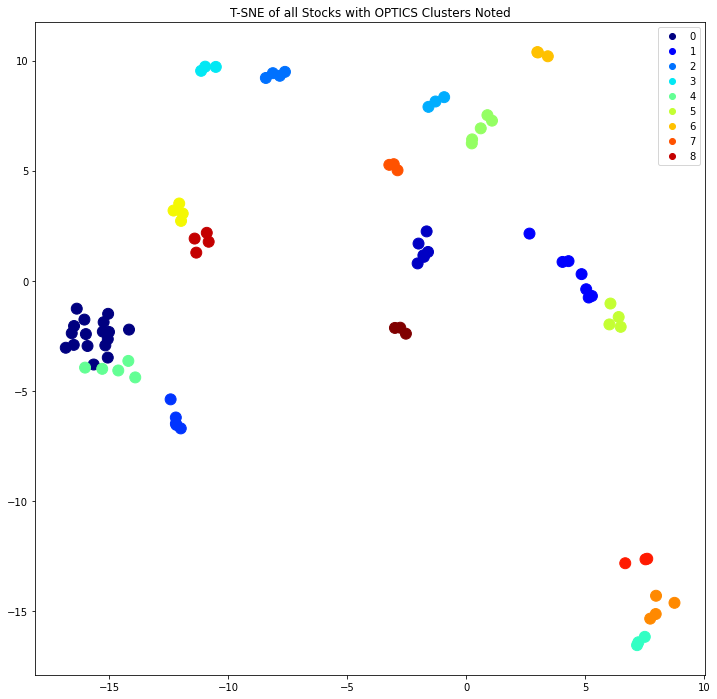

In [231]:
plt.figure(figsize=(12,12))
# plt.axis('off')
scatter = plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=120,
    # alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.jet
)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, cluster_labels)

plt.title(f'T-SNE of all Stocks with {classifier} Clusters Noted');

## Plotting data (plotly)

In [325]:
import plotly.express as px

c_label = pd.DataFrame(labels).replace(-1, np.nan).dropna(axis=0).astype('int64')[0]

fig = px.scatter(x = X_tsne[(labels!=-1), 0],
                 y = X_tsne[(labels!=-1), 1],
                 color = c_label,
                #  symbol = c_label,
                 height=700,
                #  labels = c_label,
                 size=c_label,
                 )

# fig.update_coloraxes(showscale=False)

fig.update_layout(title = f't-SNE Visualization using {model}')

fig.show()

In [261]:
### Extracting the cluster groups

cluster_labels_1 = pd.DataFrame(labels).replace(-1, np.nan).dropna(axis=0)[0]

clusters = cluster_labels_1.to_frame()\
                           .rename(columns={0: 'cluster_number'})\
                           .groupby('cluster_number').groups

clusters is the a dictionary with the cluster numbers as keys and the list of stock-tickers as corresponding values

In [267]:
### Writing to "normal" dict

CLUSTERS = {}

for cluster_number, cluster_members in clusters.items():
    CLUSTERS[int(cluster_number)] = list(cluster_members.values)

CLUSTERS

{0: [14,
  15,
  45,
  50,
  102,
  123,
  143,
  151,
  153,
  162,
  167,
  275,
  319,
  369,
  407,
  473,
  486],
 1: [20, 38, 71, 300, 318, 483],
 2: [30, 114, 170, 175, 205, 207, 329],
 3: [47, 161, 163, 285, 449],
 4: [58, 68, 307, 354],
 5: [72, 293, 418],
 6: [77, 120, 290],
 7: [89, 255, 384],
 8: [142, 165, 169, 351, 366],
 9: [183, 184, 203, 284, 457],
 10: [138, 191, 368, 453],
 11: [195, 221, 254, 260],
 12: [200, 201, 311],
 13: [253, 364, 427, 456],
 14: [269, 273, 326],
 15: [294, 355, 370],
 16: [95, 292, 353, 356],
 17: [79, 381, 480]}

In [271]:
### Reason behind "re-writing" of dictionary --> "wrong" type

print(type(clusters))
print(type(CLUSTERS))

<class 'pandas.io.formats.printing.PrettyDict'>
<class 'dict'>


14      0
15      0
20      1
30      2
38      1
       ..
457     9
473     0
480    17
483     1
486     0
Name: 0, Length: 86, dtype: int64